<a href="https://colab.research.google.com/github/irwardhana/DEVSAT_ENV/blob/main/Analisis_Sentimen_dan_Pemodelan_Topik_Ulasan_Nasabah_Perbankan_Menggunakan_Algoritma_Bidirectional_LSTM_dan_Hierarchical_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install library Sastrawi untuk stemming Bahasa Indonesia
!pip install Sastrawi
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP Libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Machine Learning & Metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPool1D

# Download resource NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Style konfigurasi
plt.style.use('ggplot')
pd.set_option('display.max_colwidth', 100)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
# Pastikan file CSV sudah diupload dengan nama yang sesuai
filename = 'dataset_bank_sentiment_1000_natural.csv'

try:
    df = pd.read_csv(filename)
    print(f"Berhasil memuat {len(df)} data.")
    print("Contoh data:")
    print(df.head())
except FileNotFoundError:
    print("Error: File tidak ditemukan. Pastikan Anda sudah mengupload file CSV.")

Berhasil memuat 1000 data.
Contoh data:
                                                       text sentiment
0  Aplikasi mobile banking sangat cepat dan mudah digunakan   positif
1       Customer service bank ini sangat ramah dan membantu   positif
2                      Suku bunga tabungan cukup kompetitif   positif
3                 Pinjaman online disetujui dalam satu hari   positif
4                  Fitur keamanan biometrik sangat membantu   positif


In [4]:
# 1. Setup Stemmer Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# 2. Setup Stopwords
stopwords_id = set(stopwords.words('indonesian'))
# Tambahkan stopwords domain bank/umum yang tidak memberi sentimen
custom_stopwords = ['yg', 'gak', 'nya', 'aja', 'sih', 'bank', 'aplikasi', 'sy',
                    'dgn', 'sdh', 'tdk', 'jd', 'jgn', 'utk', 'kalo']
stopwords_id.update(custom_stopwords)

def clean_text_indo(text):
    # Lowercase
    text = str(text).lower()
    # Hapus angka dan tanda baca
    text = re.sub(r'[^a-z ]', ' ', text)
    # Tokenisasi
    words = word_tokenize(text)
    # Filter stopwords & kata pendek
    words = [w for w in words if w not in stopwords_id and len(w) > 3]
    # Stemming (Mengubah ke kata dasar: "transaksi" -> "transaksi", "membantu" -> "bantu")
    # Note: Stemming Sastrawi agak lambat, tapi hasilnya lebih akurat untuk Indo
    clean_words = [stemmer.stem(w) for w in words]

    return " ".join(clean_words)

print("Sedang melakukan preprocessing (Cleaning & Stemming)... Mohon tunggu.")
df['clean'] = df['text'].apply(clean_text_indo)
print("Selesai!")

# Tampilkan perbandingan
print(df[['text', 'clean']].head())

Sedang melakukan preprocessing (Cleaning & Stemming)... Mohon tunggu.
Selesai!
                                                       text  \
0  Aplikasi mobile banking sangat cepat dan mudah digunakan   
1       Customer service bank ini sangat ramah dan membantu   
2                      Suku bunga tabungan cukup kompetitif   
3                 Pinjaman online disetujui dalam satu hari   
4                  Fitur keamanan biometrik sangat membantu   

                          clean  
0    mobile banking cepat mudah  
1  customer service ramah bantu  
2  suku bunga tabung kompetitif  
3            pinjam online tuju  
4    fitur aman biometrik bantu  


Analisis Frasa pada Sentimen Negatif:


/tmp/ipython-input-2719061340.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frekuensi', y='Frasa', data=df_ngram, palette='viridis')


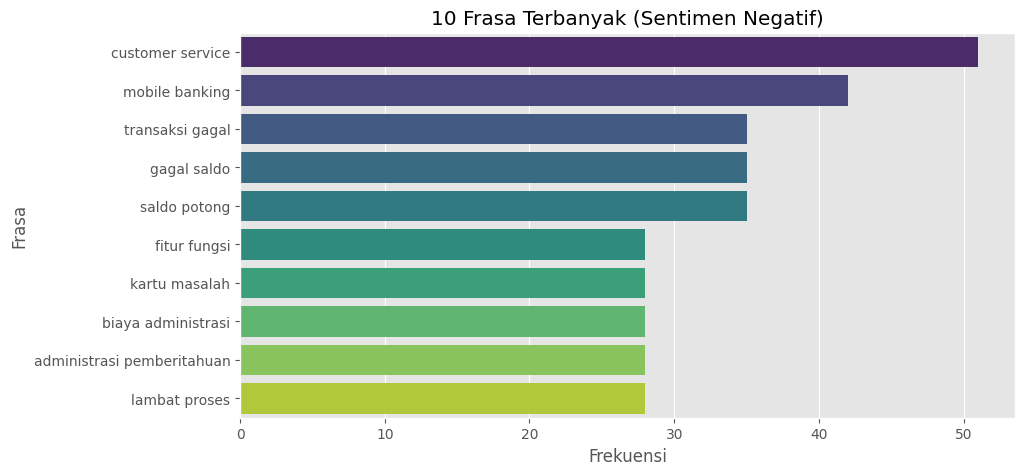

In [5]:
# Melihat kata yang sering muncul berpasangan (Bigrams)
def plot_ngrams(text_series, ngram_range=(2,2), top_n=10, title="Top Bigrams"):
    vec = CountVectorizer(ngram_range=ngram_range).fit(text_series)
    bag_of_words = vec.transform(text_series)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

    df_ngram = pd.DataFrame(words_freq[:top_n], columns=['Frasa', 'Frekuensi'])

    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frekuensi', y='Frasa', data=df_ngram, palette='viridis')
    plt.title(title)
    plt.show()

# Plot Bigram untuk sentimen Negatif (Mencari akar masalah)
print("Analisis Frasa pada Sentimen Negatif:")
plot_ngrams(df[df['sentiment']=='negatif']['clean'], title="10 Frasa Terbanyak (Sentimen Negatif)")

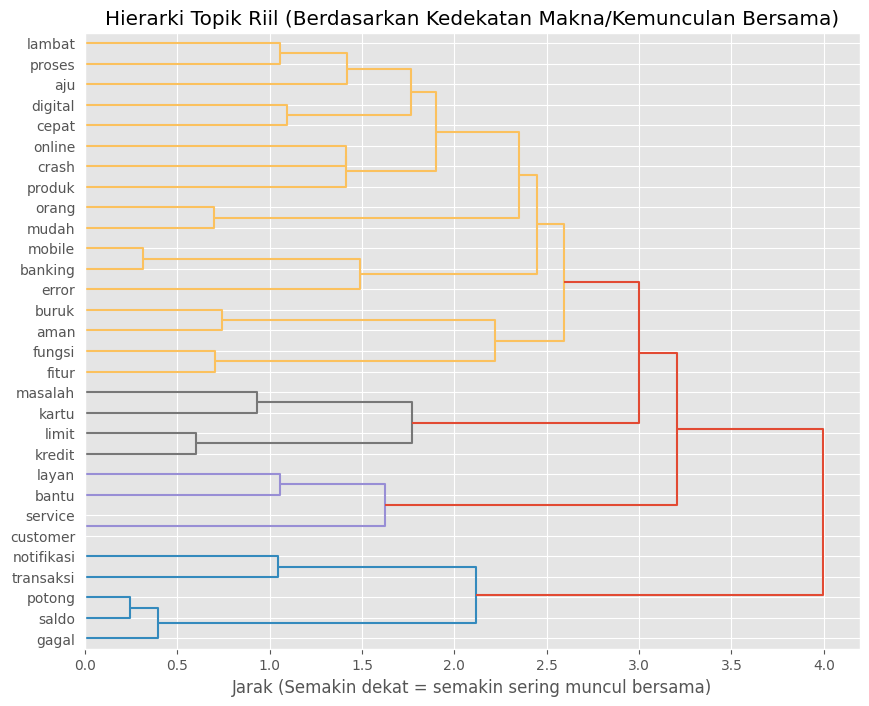

In [6]:
# 1. Hitung TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df['clean'])
terms = tfidf.get_feature_names_out()

# 2. Ambil 30 kata dengan bobot tertinggi global
top_indices = np.argsort(np.asarray(X.sum(axis=0)).ravel())[-30:][::-1]
top_words = [terms[i] for i in top_indices]
top_words_vec = X[:, top_indices].T.toarray() # Transpose agar baris = kata

# 3. Hitung Jarak (1 - Cosine Similarity)
dist_matrix = 1 - cosine_similarity(top_words_vec)

# 4. Clustering Hierarki
linked = linkage(dist_matrix, 'ward')

plt.figure(figsize=(10, 8))
dendrogram(linked, labels=top_words, orientation='right', leaf_font_size=10)
plt.title('Hierarki Topik Riil (Berdasarkan Kedekatan Makna/Kemunculan Bersama)')
plt.xlabel('Jarak (Semakin dekat = semakin sering muncul bersama)')
plt.show()

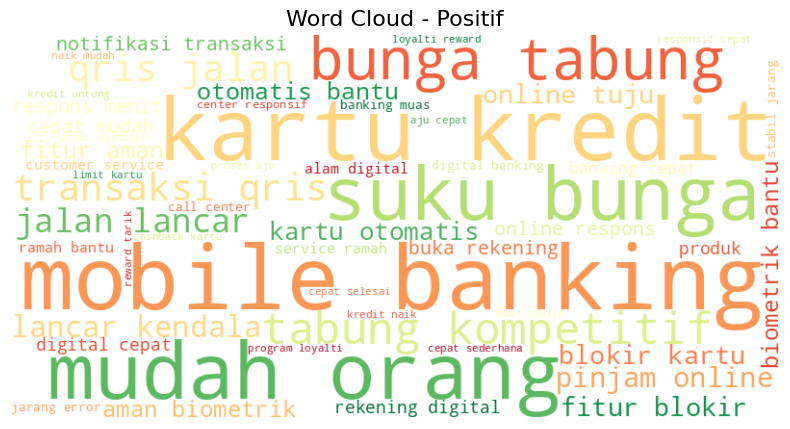

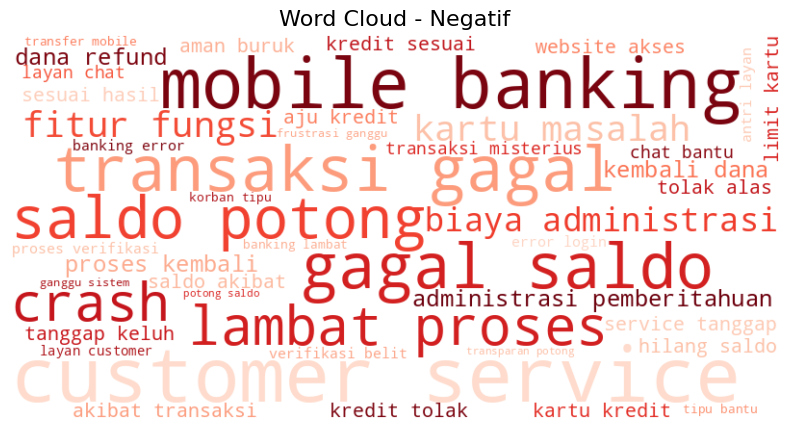

In [7]:
# Pisahkan teks positif dan negatif
pos_text = " ".join(df[df['sentiment'] == 'positif']['clean'])
neg_text = " ".join(df[df['sentiment'] == 'negatif']['clean'])

def show_wordcloud(text, title, color_func=None):
    wc = WordCloud(width=800, height=400, background_color='white',
                   colormap='RdYlGn' if title=='Positif' else 'Reds').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {title}', fontsize=16)
    plt.show()

show_wordcloud(pos_text, 'Positif')
show_wordcloud(neg_text, 'Negatif')

In [8]:
# 1. Label Encoding (Positif=1, Negatif=0)
y = df['sentiment'].map({'positif': 1, 'negatif': 0}).values

# 2. Tokenisasi Keras
MAX_VOCAB = 3000
MAX_LEN = 30 # Panjang kalimat rata-rata yang diambil

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean'])
sequences = tokenizer.texts_to_sequences(df['clean'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# 3. Split Data Train/Test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

print(f"Shape Train: {X_train.shape}")
print(f"Shape Test: {X_test.shape}")

Shape Train: (800, 30)
Shape Test: (200, 30)


In [9]:
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=64, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)), # Bidirectional agar lebih pintar membaca konteks
    Dropout(0.5), # Mencegah overfitting
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') # Output 0 atau 1
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Training Model
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.5437 - loss: 0.6908 - val_accuracy: 0.8950 - val_loss: 0.6480
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8881 - loss: 0.5838 - val_accuracy: 0.9150 - val_loss: 0.2464
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9658 - loss: 0.1530 - val_accuracy: 1.0000 - val_loss: 0.0391
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9993 - loss: 0.0239 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 7.8971e-04
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 3.3645e-04
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 3.6352e-04
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 1.0000 - loss: 9.2652e-04 - val_ac

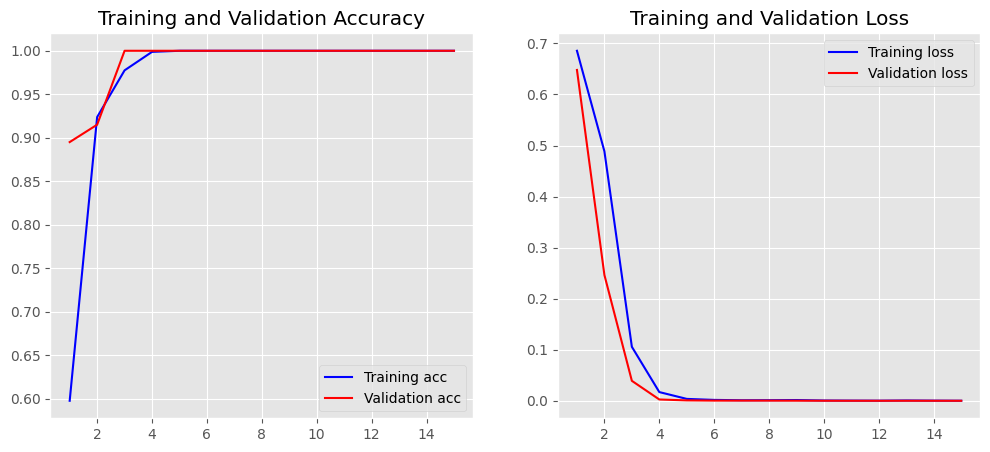


Akurasi pada Data Test: 100.00%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


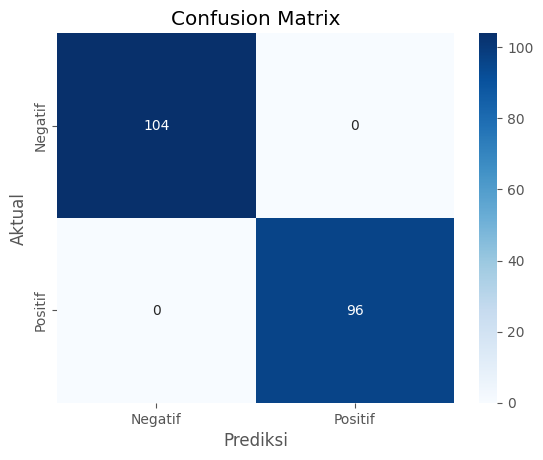

In [10]:
# Plot Akurasi & Loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_history(history)

# Evaluasi Final pada Data Test
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nAkurasi pada Data Test: {accuracy*100:.2f}%")

# Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.title('Confusion Matrix')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime, timedelta
import random
import re

# Load Data (Pastikan file csv ada di folder yang sama)
df = pd.read_csv('dataset_bank_sentiment_1000_natural.csv')

# Fungsi pembersih sederhana untuk visualisasi
def clean_text_viz(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9 ]', ' ', text)
    return text

df['clean'] = df['text'].apply(clean_text_viz)

# [OPSIONAL] Simulasi Tanggal (Hapus jika Anda punya kolom tanggal asli)
# Kita buat tanggal acak antara Jan-Jun 2024
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 6, 30)
days_range = (end_date - start_date).days
np.random.seed(42) # Agar hasil tetap sama
df['tanggal'] = [start_date + timedelta(days=np.random.randint(0, days_range)) for _ in range(len(df))]
df['tanggal'] = pd.to_datetime(df['tanggal'])

/tmp/ipython-input-1013987471.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=df, palette={'positif': 'green', 'negatif': 'red'})


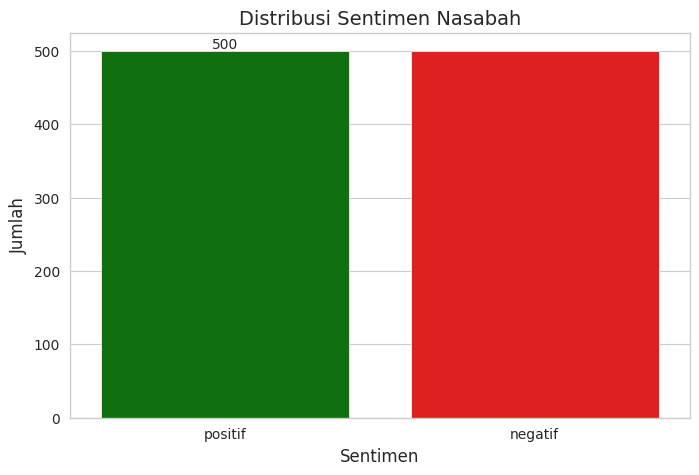

/tmp/ipython-input-1013987471.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Term', data=df_pos, palette='Greens_r')


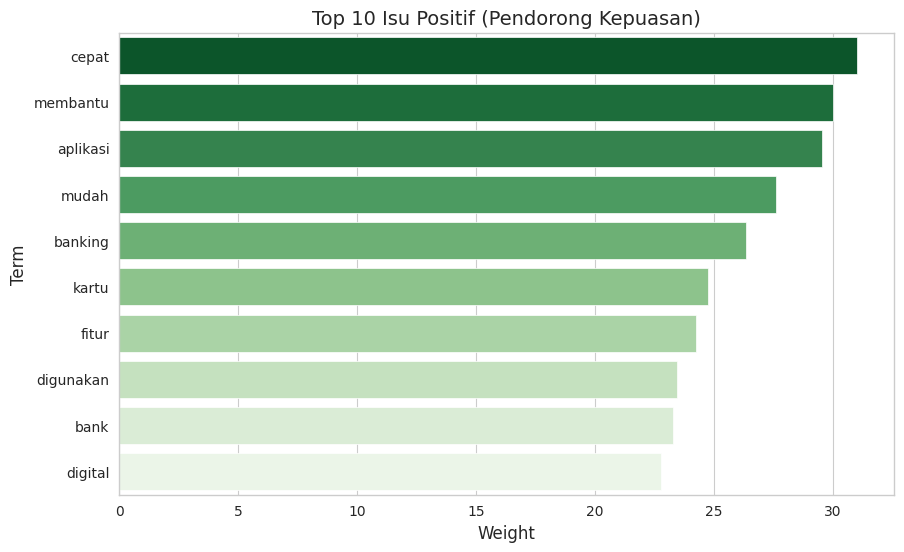

/tmp/ipython-input-1013987471.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Term', data=df_neg, palette='Reds_r')


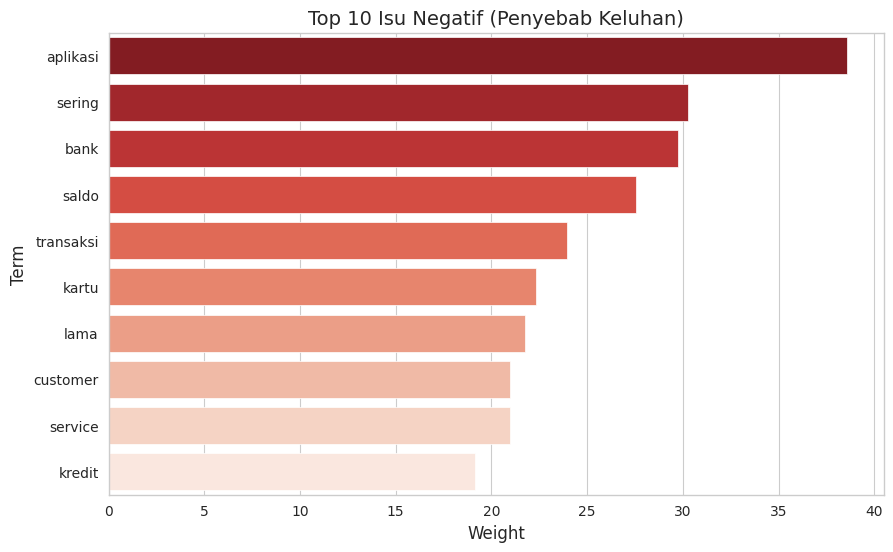

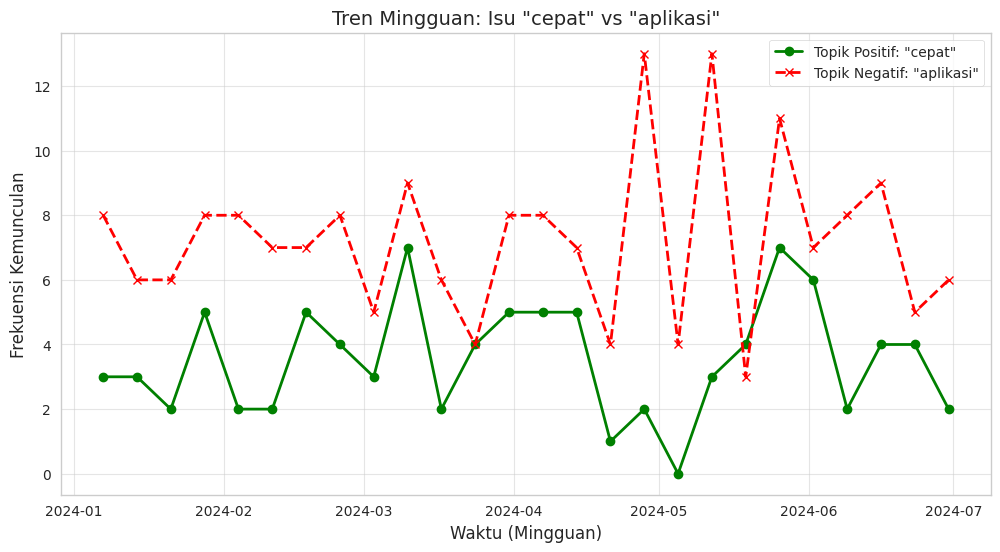

In [12]:
# Setup Gaya Visualisasi
sns.set_style("whitegrid")

# 1. GRAFIK DISTRIBUSI SENTIMEN
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='sentiment', data=df, palette={'positif': 'green', 'negatif': 'red'})
plt.title('Distribusi Sentimen Nasabah', fontsize=14)
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.bar_label(ax.containers[0])
plt.show()

# 2. ANALISIS BOBOT ISU (TF-IDF)
def get_top_keywords(data, max_features=10):
    tfidf = TfidfVectorizer(max_features=1000, stop_words=['yang', 'dan', 'di', 'ini', 'itu', 'untuk', 'dari', 'saya', 'tidak', 'yg', 'gak', 'nya', 'aja', 'sih', 'bisa', 'ada', 'sangat'])
    matrix = tfidf.fit_transform(data)
    sum_scores = matrix.sum(axis=0)
    words_freq = [(word, sum_scores[0, idx]) for word, idx in tfidf.vocabulary_.items()]
    return sorted(words_freq, key = lambda x: x[1], reverse=True)[:max_features]

# Hitung Topik
top_pos = get_top_keywords(df[df['sentiment']=='positif']['clean'])
top_neg = get_top_keywords(df[df['sentiment']=='negatif']['clean'])
df_pos = pd.DataFrame(top_pos, columns=['Term', 'Weight'])
df_neg = pd.DataFrame(top_neg, columns=['Term', 'Weight'])

# Plot Bobot Positif
plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Term', data=df_pos, palette='Greens_r')
plt.title('Top 10 Isu Positif (Pendorong Kepuasan)', fontsize=14)
plt.show()

# Plot Bobot Negatif
plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Term', data=df_neg, palette='Reds_r')
plt.title('Top 10 Isu Negatif (Penyebab Keluhan)', fontsize=14)
plt.show()

# 3. GRAFIK AKTIVITAS TOPIK DARI WAKTU KE WAKTU
# Ambil kata kunci teratas (Rank 1) dari masing-masing sentimen
keyword_pos = df_pos.iloc[0]['Term'] # Biasanya: 'cepat'/'mudah'
keyword_neg = df_neg.iloc[0]['Term'] # Biasanya: 'saldo'/'gagal'

# Tandai kemunculan topik di setiap baris
df['has_pos_issue'] = df['clean'].apply(lambda x: 1 if keyword_pos in x else 0)
df['has_neg_issue'] = df['clean'].apply(lambda x: 1 if keyword_neg in x else 0)

# Resample per Minggu (Weekly)
trend = df.set_index('tanggal').resample('W')[['has_pos_issue', 'has_neg_issue']].sum()

# Plot Time Series
plt.figure(figsize=(12, 6))
plt.plot(trend.index, trend['has_pos_issue'], marker='o', color='green', linewidth=2, label=f'Topik Positif: "{keyword_pos}"')
plt.plot(trend.index, trend['has_neg_issue'], marker='x', color='red', linewidth=2, linestyle='--', label=f'Topik Negatif: "{keyword_neg}"')
plt.title(f'Tren Mingguan: Isu "{keyword_pos}" vs "{keyword_neg}"', fontsize=14)
plt.xlabel('Waktu (Mingguan)')
plt.ylabel('Frekuensi Kemunculan')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()